Stage 1 Test RMSE: 5.0258184854663925 R2: -0.54557822635548
Stage 1 Feature Importances:
                Feature  Importance
0   facebook_spend_log    0.456455
1     tiktok_spend_log    0.230622
2  instagram_spend_log    0.158259
3   snapchat_spend_log    0.154664
Stage 2 Train RMSE: 1.8319314399837734 R2: 0.6794907213539818
Stage 2 Test RMSE: 2.5425857773518152 R2: 0.33598672725840184
Stage 2 Feature Importances:
                    Feature  Importance
3     average_price_scaled    0.369180
2               sms_send_k    0.225828
0        google_spend_pred    0.139372
4  followers_growth_scaled    0.136320
1            emails_send_k    0.111013
5                        1    0.018288


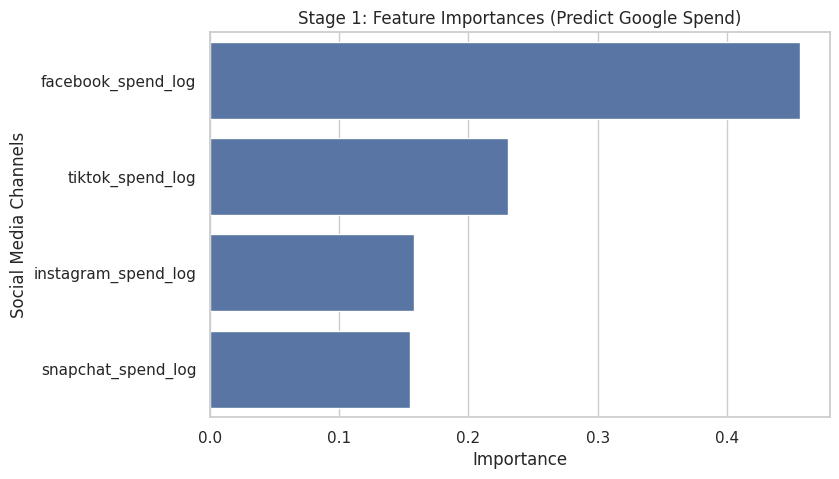

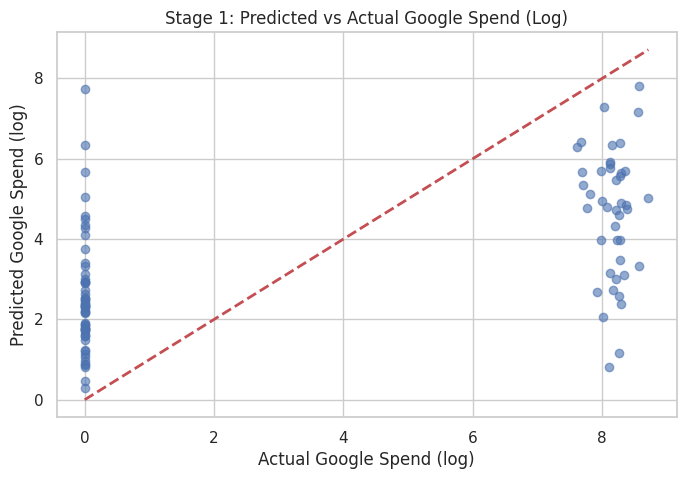

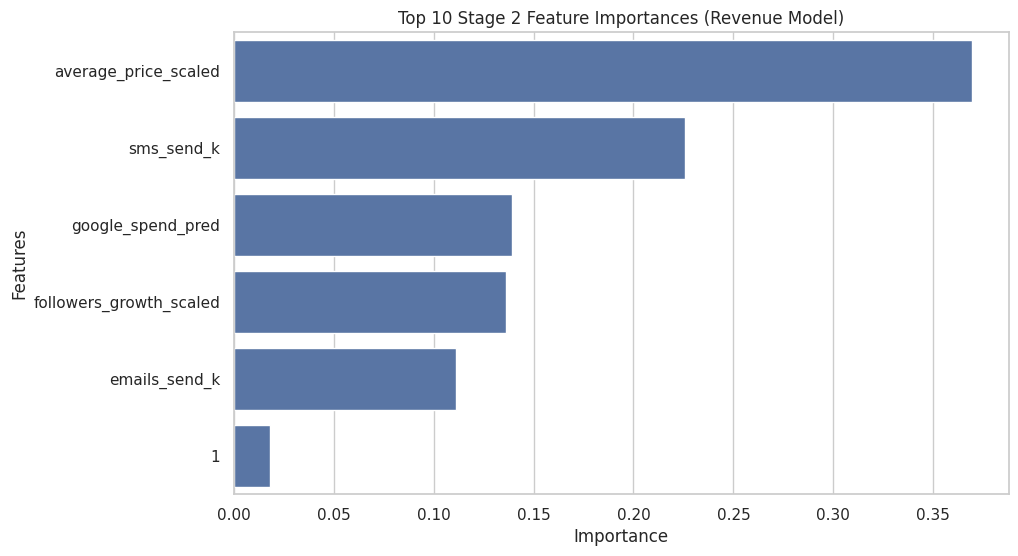

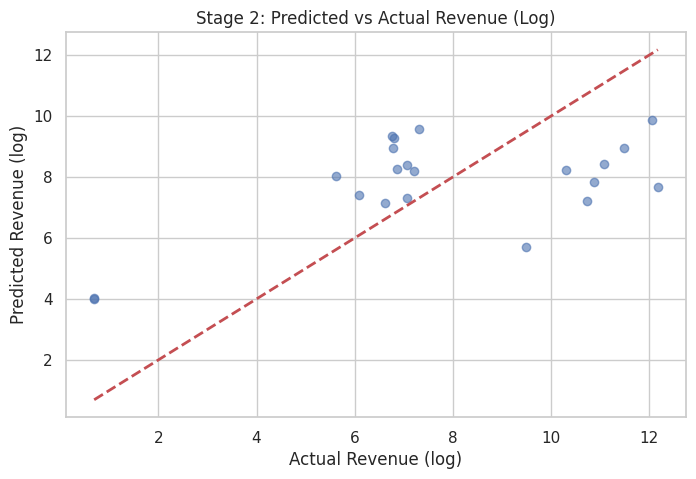

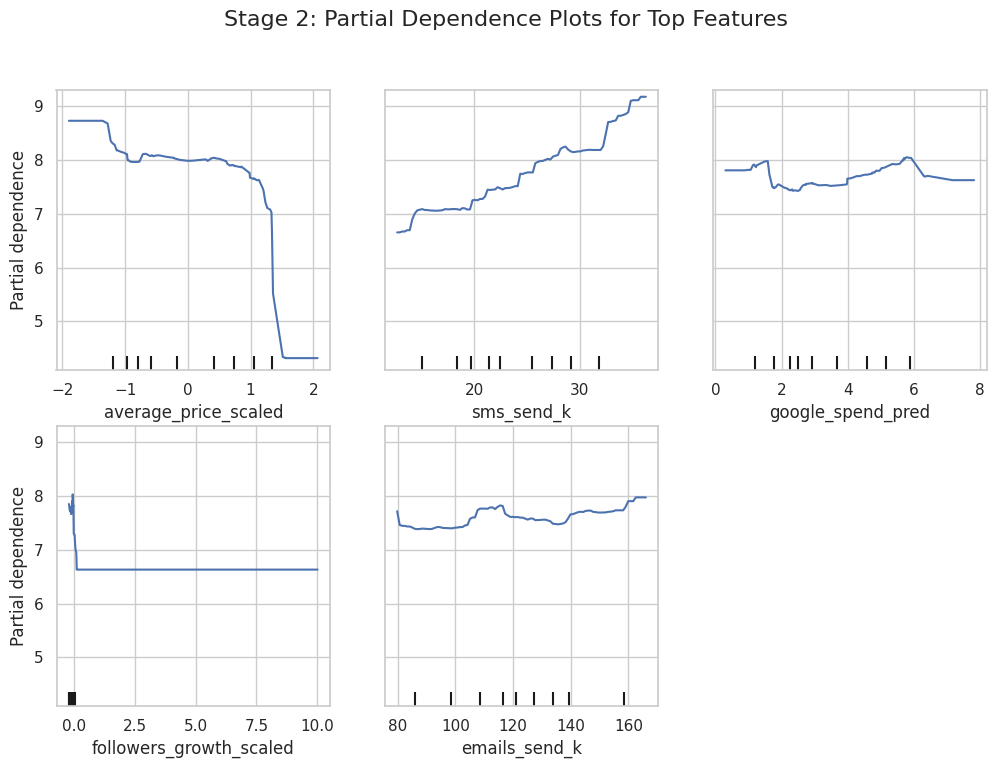

In [1]:
# ==============================
# MMM Random Forest Model + Plots
# ==============================

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import PartialDependenceDisplay

sns.set(style="whitegrid")
plt.rcParams.update({'figure.max_open_warning': 0})

# -----------------------------
# Load dataset
# -----------------------------
dataset = pd.read_csv('Assessment 2 - MMM Weekly.csv')

# ---- Time features ----
dataset["week"] = pd.to_datetime(dataset["week"])
dataset["week_number"] = (dataset["week"] - dataset["week"].min()).dt.days // 7 + 1
dataset["year"] = dataset["week"].dt.year
dataset["month"] = dataset["week"].dt.month
dataset["quarter"] = dataset["week"].dt.quarter

# ---- Lag features ----
dataset["revenue_lag1"] = dataset["revenue"].shift(1)
dataset["revenue_lag2"] = dataset["revenue"].shift(2)

# Drop rows with NA from lag
dataset = dataset.dropna().reset_index(drop=True)

# ---- Log-transform spend and revenue ----
spend_vars = ["facebook_spend","google_spend","tiktok_spend","instagram_spend","snapchat_spend"]
for col in spend_vars:
    dataset[f"{col}_log"] = np.log1p(dataset[col])
dataset["revenue_log"] = np.log1p(dataset["revenue"])

# ---- Categorical features ----
dataset["promotions_cat"] = dataset["promotions"].astype("category")
promotions_dummies = pd.get_dummies(dataset["promotions_cat"], drop_first=True)
dataset = pd.concat([dataset, promotions_dummies], axis=1)

# ---- Other scaled features ----
dataset["emails_send_k"] = dataset["emails_send"] / 1000
dataset["sms_send_k"] = dataset["sms_send"] / 1000
dataset["followers_lag1"] = dataset["social_followers"].shift(1)
dataset["followers_growth"] = (dataset["social_followers"] - dataset["followers_lag1"]) / dataset["followers_lag1"]
dataset["followers_growth"] = dataset["followers_growth"].fillna(0).clip(-1,1)

scaler = StandardScaler()
dataset["followers_growth_scaled"] = scaler.fit_transform(dataset[["followers_growth"]])
dataset["average_price_scaled"] = scaler.fit_transform(dataset[["average_price"]])

# ==============================
# Stage 1: Predict Google spend from social media
# ==============================
X_social = dataset[["facebook_spend_log","tiktok_spend_log","instagram_spend_log","snapchat_spend_log"]]
y_google = dataset["google_spend_log"]

split_index = int(len(dataset) * 0.8)
X_train = X_social.iloc[:split_index]
y_train = y_google.iloc[:split_index]
X_test = X_social.iloc[split_index:]
y_test = y_google.iloc[split_index:]

rf_stage1 = RandomForestRegressor(n_estimators=200, max_depth=5, random_state=42)
rf_stage1.fit(X_train, y_train)

dataset["google_spend_pred"] = rf_stage1.predict(X_social)

y_pred_test1 = rf_stage1.predict(X_test)
rmse1 = np.sqrt(mean_squared_error(y_test, y_pred_test1))
r2_1 = r2_score(y_test, y_pred_test1)
print("Stage 1 Test RMSE:", rmse1, "R2:", r2_1)

feature_importances1 = pd.DataFrame({
    "Feature": X_social.columns,
    "Importance": rf_stage1.feature_importances_
}).sort_values(by="Importance", ascending=False)
print("Stage 1 Feature Importances:\n", feature_importances1)

# ==============================
# Stage 2: Revenue model using mediator + levers
# ==============================
dataset.columns = dataset.columns.astype(str)  # ensure all string

promotions_cols = promotions_dummies.columns.astype(str).tolist()
stage2_features = ["google_spend_pred","emails_send_k","sms_send_k",
                   "average_price_scaled","followers_growth_scaled"] + promotions_cols

X_stage2 = dataset[stage2_features].copy()
X_stage2.columns = X_stage2.columns.astype(str)
y_stage2 = dataset["revenue_log"].copy()

# Handle Inf/NaN
X_stage2.replace([np.inf, -np.inf], 0, inplace=True)
y_stage2.replace([np.inf, -np.inf], 0, inplace=True)
X_stage2.fillna(0, inplace=True)
y_stage2.fillna(0, inplace=True)

split_index2 = int(len(X_stage2) * 0.8)
X_train2 = X_stage2.iloc[:split_index2]
y_train2 = y_stage2.iloc[:split_index2]
X_test2 = X_stage2.iloc[split_index2:]
y_test2 = y_stage2.iloc[split_index2:]

rf_stage2 = RandomForestRegressor(
    n_estimators=300,
    max_depth=6,
    max_features='sqrt',
    min_samples_split=5,
    min_samples_leaf=3,
    random_state=42
)
rf_stage2.fit(X_train2, y_train2)

y_pred_train2 = rf_stage2.predict(X_train2)
y_pred_test2 = rf_stage2.predict(X_test2)

rmse_train2 = np.sqrt(mean_squared_error(y_train2, y_pred_train2))
rmse_test2 = np.sqrt(mean_squared_error(y_test2, y_pred_test2))
r2_train2 = r2_score(y_train2, y_pred_train2)
r2_test2 = r2_score(y_test2, y_pred_test2)

print("Stage 2 Train RMSE:", rmse_train2, "R2:", r2_train2)
print("Stage 2 Test RMSE:", rmse_test2, "R2:", r2_test2)

feature_importances2 = pd.DataFrame({
    "Feature": X_stage2.columns,
    "Importance": rf_stage2.feature_importances_
}).sort_values(by="Importance", ascending=False)
print("Stage 2 Feature Importances:\n", feature_importances2)

# ==============================
# PLOTTING
# ==============================

# Stage 1: Feature importance
plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature", data=feature_importances1)
plt.title("Stage 1: Feature Importances (Predict Google Spend)")
plt.xlabel("Importance")
plt.ylabel("Social Media Channels")
plt.show()

# Stage 1: Predicted vs Actual
plt.figure(figsize=(8,5))
plt.scatter(dataset["google_spend_log"], dataset["google_spend_pred"], alpha=0.6)
plt.plot([dataset["google_spend_log"].min(), dataset["google_spend_log"].max()],
         [dataset["google_spend_log"].min(), dataset["google_spend_log"].max()],
         'r--', linewidth=2)
plt.title("Stage 1: Predicted vs Actual Google Spend (Log)")
plt.xlabel("Actual Google Spend (log)")
plt.ylabel("Predicted Google Spend (log)")
plt.show()

# Stage 2: Feature importance (Top 10)
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=feature_importances2.head(10))
plt.title("Top 10 Stage 2 Feature Importances (Revenue Model)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

# Stage 2: Predicted vs Actual
plt.figure(figsize=(8,5))
plt.scatter(y_test2, y_pred_test2, alpha=0.6)
plt.plot([y_test2.min(), y_test2.max()],
         [y_test2.min(), y_test2.max()],
         'r--', linewidth=2)
plt.title("Stage 2: Predicted vs Actual Revenue (Log)")
plt.xlabel("Actual Revenue (log)")
plt.ylabel("Predicted Revenue (log)")
plt.show()

# Stage 2: Partial Dependence Plots for top 5 features
top_features_stage2 = feature_importances2.head(5)["Feature"].tolist()
fig, ax = plt.subplots(figsize=(12,8))
PartialDependenceDisplay.from_estimator(rf_stage2, X_stage2, features=top_features_stage2, ax=ax)
plt.suptitle("Stage 2: Partial Dependence Plots for Top Features", fontsize=16)
plt.show()
